# Proyecto 04 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

## Objetivos



A partir del trabajo realizado en el proyecto 3 de NLP usaré el dataset de reviews para hacer 'Sentiment Analysis' sobre los reviews del dataset. Para poder lograr este objetivo utilizaré la librería "pysentimiento" que tiene que contiene un modelo pre-entrenado para sentiment analysis, el momento en ninguno de los proyectos este tipo de modelos.

Además crearé una webapp que muestre un resultado sobre la frase ingresada por el usuario (si es positiva, neutra o negativa). Para lograrlo, utilizaré la misma librería utilizada en este notebook y Streamlit, herramienta que permite crear webapps.

## Supuestos

Para poder hacer un Sentiment Analysis sobre el dataset debo transformar la columna 'Stars' del dataset y convertirla en una etiqueta que sea "Positivo", "Neutro" o "Negativo".

El criterio que seguiré para hacer esta transformación será:
- De 1 a 2 Estrellas consideraré el review como negativo
- Con 3 estrellas consideraré el review como neutro
- De 4 a 5 Estrellas consideraré el review como positivo

## Preparación del dataset

In [88]:
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
#Importo el dataset
ds= pd.read_json('dataset_es_train.json', lines= True)

In [90]:
#Elimino las columnas que no necesito y me quedo con las columnas 'review_body' y 'stars'
ds = ds[['review_body','stars']]

In [91]:
#Revisamos la forma del dataset filtrado
ds.shape

(200000, 2)

In [92]:
#Primero hagamos un contemos sobre los grupos de estrellas de 1 a 3, y de 4 a 5
cont_neg = ds[ds['stars'] < 3]
print("Reviews Negativos: " + str(cont_neg.shape[0]))
cont_neu = ds[ds['stars'] == 3]
print("Reviews Neutros: " + str(cont_neu.shape[0]))
cont_pos = ds[ds['stars'] > 3]
print("Reviews Positivos: " + str(cont_pos.shape[0]))

Reviews Negativos: 80000
Reviews Neutros: 40000
Reviews Positivos: 80000


In [93]:
#Ahora convertimos las etiquetas con el criterio definido anteriormente

#Cambiamos los nombres de las columnas del dataset
ds.columns = ['review','label']


ds.label = ds.label.replace({1: "NEGATIVE",2: "NEGATIVE",3: "NEUTRAL",4: "POSITIVE",5: "POSITIVE"})

In [101]:
#Controlamos que la cantidad de filas coincidan con los originales (previos al cambio)
ds[ds['label']=="NEGATIVE"].shape[0]

80000

## Clasificación de las muestras

In [130]:
#Importo la librería a utilizar para sentiment analysis en español
#La librería y documentación está disponible en: https://github.com/finiteautomata/pysentimiento/

from pysentimiento import SentimentAnalyzer

In [60]:
#Defino el analizador
analyzer = SentimentAnalyzer()

In [61]:
#Hacemos una prueba
analyzer.predict("En acámica hay muy buenos profesores")

'POS'

In [62]:
#Probamos con una frase negativa
analyzer.predict("No sos bueno programando")

'NEG'

In [63]:
#El modelo soporta un máximo de 500 caracteres para la frase a analizar,
# para no tener problemas cortamos el string del review en ese valor
ds['review'] = ds['review'].str[:500]

Para poder aplicar el analisis sobre el dataset voy a crear una función que tome cada review y devuelva una predicción.

In [66]:
def sentiment_pred(frase):
    prediccion = analyzer.predict(frase)
    return prediccion

Ahora aplico la funcion a cada una de las reviews en el dataset, obteniendo la predicción para cada etiqueta.

In [14]:
t_pred = ds['review'].apply(lambda x: sentiment_pred(x))

Junto el dataset original con las predicciones en un mismo dataset

In [95]:
y_pred = pd.DataFrame(t_pred)
y_pred.columns = ['y_pred']

In [102]:
df = pd.concat([ds,y_pred],axis=1)

In [103]:
df.shape

(200000, 3)

In [104]:
df.head()

,review,label,y_pred
0,Nada bueno se me fue ka pantalla en menos de 8...,NEGATIVE,NEG
1,"Horrible, nos tuvimos que comprar otro porque ...",NEGATIVE,NEG
2,Te obligan a comprar dos unidades y te llega s...,NEGATIVE,NEG
3,"No entro en descalificar al vendedor, solo pue...",NEGATIVE,NEG
4,Llega tarde y co la talla equivocada,NEGATIVE,NEG


In [107]:
dataset = df

In [109]:
dataset.label.unique()

array(['NEGATIVE', 'NEUTRAL', 'POSITIVE'], dtype=object)

In [110]:
dataset["y_pred"] = dataset["y_pred"].replace({"NEG": "NEGATIVE","POS":"POSITIVE", "NEU":"NEUTRAL"})

In [111]:
dataset.head()

,review,label,y_pred
0,Nada bueno se me fue ka pantalla en menos de 8...,NEGATIVE,NEGATIVE
1,"Horrible, nos tuvimos que comprar otro porque ...",NEGATIVE,NEGATIVE
2,Te obligan a comprar dos unidades y te llega s...,NEGATIVE,NEGATIVE
3,"No entro en descalificar al vendedor, solo pue...",NEGATIVE,NEGATIVE
4,Llega tarde y co la talla equivocada,NEGATIVE,NEGATIVE


Ahora veo que tan bien predijo el modelo pre-entrenado respecto de las etiquetas originales:

In [112]:
dataset["label"].unique()

array(['NEGATIVE', 'NEUTRAL', 'POSITIVE'], dtype=object)

In [113]:
dataset["y_pred"].unique()

array(['NEGATIVE', 'NEUTRAL', 'POSITIVE'], dtype=object)

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score

### Conclusiones

In [127]:
acc = accuracy_score(df['label'],df['y_pred'])

print("El accuracy del modelo es: " + str(acc))

El accuracy del modelo es: 0.655855


El accuracy obtenido para el modelo no es tan alto teniendo en cuenta que el accuracy de estos modelos suele rondar el 90%. Esto puede deberse a un sesgo del modelo para clasificar algún tipo de etiqueta. Lo analizaremos con un heatmap.

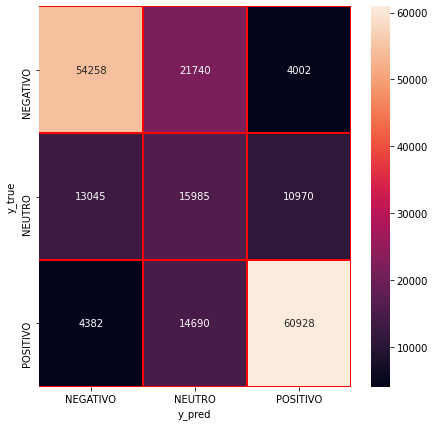

In [128]:
from sklearn.metrics import confusion_matrix

cm1=confusion_matrix(df['label'],df['y_pred'])
f,ax=plt.subplots(figsize=(7,7))
sns.heatmap(cm1, xticklabels=["NEGATIVO", "NEUTRO", "POSITIVO"], yticklabels=["NEGATIVO", "NEUTRO", "POSITIVO"],annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

En el heatmap podemos ver que el modelo distingue muy bien los reviews positivos de los negativos y el mayor error suele estar sobre los reviews neutros, donde si confunde reviews positivos y negativos como neutros. 

Este comportamiento puede estar relacionado al criterio utilizado para convertir las estrellas a etiquetas que representen sentimientos, una review con 3 estrellas puede no ser un comentario neutro y dependerá del criterio de la persona para puntuar el producto. Si dejaramos de lado los comentarios neutros es probablemente el modelo clasificaría mejor.

## Web App de Sentiment Analysis

Como mencioné al principio del informe, generé una webapp con Streamlit que utiliza la misma librería "pysentimiento" utilizada en el notebook.

El archivo de la app se encuentra en el siguiente repositorio de github:
https://github.com/santiagomsosa/sentiment-analysis-app/blob/main/proyecto4.py

### Capturas de la APP

#### Pantalla Inicial

[![Foo](https://i.ibb.co/P9gjrYz/1.png)](http://google.com.au/)

#### Comentario Positivo

[![Foo](https://i.ibb.co/gD0wLy2/2.png)](http://google.com.au/)

#### Comentario Neutro

[![Foo](https://i.ibb.co/8B7nm4w/4.png)](http://google.com.au/)

#### Comentario Negativo

[![Foo](https://i.ibb.co/3M3mjqD/3.png)](http://google.com.au/)